# Code Implementation

I implement the periodic kNN using a KD tree on the position array. I mirrored and padded the array on both ends to ensure periodic boundary.

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.neighbors import KDTree
import networkx as nx

#record seed
seed = time.time_ns()
seed = np.clip(seed, 0, 2**32-1)
print("random seed", seed)
np.random.seed(seed)

random seed 4294967295


In [ ]:
class Simulation:

  """
  1D Viscek Model of Flocking with k-nearest-neighbors rule and homogeneous noise.
  """

  def __init__(self, tau=1, k=3, N=100, size=100, simtime=500,
               speed=1.0,outtime=1.0,noise=0.1):
    #parameters
    self.params = dict()
    self.params['N'] = N #number of agents
    self.params['size'] = size #size of system
    self.params['simtime'] = simtime
    self.params['tau'] = tau #relaxation time (stationary rate)
    self.params['k'] = k #number of neighbors
    self.params['outtime'] = outtime
    self.params['speed']=speed #constant magnitude of velocity
    self.params['noise'] = noise
    self.params['dt'] = tau/10
    self.params['steps'] = int(self.params['simtime']/self.params['dt'])
    self.params['sigma_dt'] = self.params['noise']/np.sqrt(self.params['dt'])
    self.params['outstep'] = int(self.params['outtime']/self.params['dt'])
  def init_data(self):
    #agents
    self.agentData=dict()
    self.agentData['x']=self.params['size']*np.random.random(size=self.params['N'])
    self.agentData['phi']=2*np.pi*np.random.random(size=self.params['N'])
    self.agentData['force']=np.zeros(self.params['N'])
    self.agentData['v']=self.params['speed']*np.cos(self.agentData['phi'])

    #system
    self.out=dict()
    self.out['x']=[]
    self.out['v']=[]
    self.out['phi']=[]
    self.out['force']=[]
    self.out['t']=[]
    self.graph = {'from':[],'to':[],'data':[]}
    return

  def update_interaction(self):
    #get nearest neighbors
    x = self.agentData['x']
    pad = np.pad(x, (int(len(x)/2), int(len(x)/2)), 'reflect') #mirror for periodic boundary
    pad = np.reshape(pad,(-1,1))
    x = np.reshape(x,(-1,1))
    tree = KDTree(x) #KD tree where 2 leaf is 2 partition
    dist,ind = tree.query(pad,k=self.params['k']+2) #2 is mirrored self
    nbs = ind[:,2:] #get knn for each agent

    #update force
    for agent in range(self.params['N']):
      forces = []
      for n in nbs[agent]:
        theta = self.agentData['phi'][n]-self.agentData['phi'][agent]
        if theta < -np.pi: 
          theta += 2*np.pi
        if theta > np.pi:
          theta -= 2*np.pi
        forces.append(theta)
      force = np.average(forces)
      #normalize phi = [0, pi]
      if force > np.pi:
          force -= np.pi
      elif force < -np.pi:
          force += np.pi
      self.agentData['force'][agent] = force
    return
        
  def update_agents(self):
    #apply force with noise on angle
    noise = np.random.normal(0,1,self.params['N'])
    dphidt = (self.agentData['force']/self.params['tau']) \
              + (noise * self.params['sigma_dt'])
    #update data
    self.agentData['phi'] += dphidt * self.params['dt']
    self.agentData['v'] = self.params['speed']*np.cos(self.agentData['phi'])
    self.agentData['x'] += self.agentData['v']*self.params['dt']

    #ensure periodic x=[0,L], phi=[0,2pi]
    for i in range(self.params['N']):
      if self.agentData['phi'][i] > 2*np.pi:
        self.agentData['phi'][i] = self.agentData['phi'][i]%2*np.pi
      if self.agentData['phi'][i] < 0:
        self.agentData['phi'][i] += 2*np.pi
      if self.agentData['x'][i] > self.params['size']:
        self.agentData['x'][i] -= self.params['size']
      if self.agentData['x'][i] < 0:
        self.agentData['x'][i] += self.params['size']
    return
  
  def document(self,step):
    #record state data
    self.out['x'].append(np.copy(self.agentData['x']))
    self.out['v'].append(np.copy(self.agentData['v']))
    self.out['phi'].append(np.copy(self.agentData['phi']))
    self.out['force' ].append(np.copy(self.agentData['force']))
    self.out['t'].append(step*self.params['dt'])

  def run(self):
    #one run through steps
    self.init_data()
    self.document(0)
    for step in range(self.params['steps']):
      self.update_interaction()
      self.update_agents()
      self.document(step)
    #returns: parameters, output
    return self.params, self.out

# Plotting helper functions

In [ ]:
def graphit(params,outData):

  #preprocessing
  g = 1/(params['tau']*(params['noise']/params['dt'])**2)
  x=np.reshape(outData['x'],(-1,params['N']))
  t=np.reshape(outData['t'],(-1,1))
  phis=np.reshape(outData['phi'],(-1,params['N']))
  
  #graph
  net = {'source':[],'dest':[],'data':[]}
  lastx = x[-1]
  for agent in range(params['N']):
    #boundary periodic
    bydist = []
    for nb in range(params['N']):
      dist = np.abs(lastx[nb] - lastx[agent])
      if dist > params['size']/2:
        dist = params['size'] - dist
      bydist.append(dist)
    nb = np.argsort(bydist)[1:params['k']+1]
    forces = []
    for n in nb:
      net['source'].append(agent)
      net['dest'].append(n)
      net['data'].append(np.abs(lastx[nb] - lastx[agent]))

  

  graph = nx.DiGraph()
  graph.add_nodes_from([i for i in range(params['N'])])
  for i in graph.nodes():
    graph.nodes[i]['theta'] = phis[-1][i]
  for u,v,d in zip(net['source'], net['dest'],net['data']): 
    graph.add_edge(u, v,length=d)
  pos=nx.spring_layout(graph)
  vmin = -1
  vmax = 1
  sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
  sm.set_array([])
  cbar = plt.colorbar(sm)
  colors = [np.sin(graph.nodes[i]['theta']) for i in graph.nodes()]
  nx.draw(graph,
          node_color=colors,
          pos=pos,cmap='viridis',vmin=vmin,vmax=vmax)
  nx.draw_networkx_edges(
    graph, pos,  
    width=1, 
    label="S",
    arrowstyle='-|>')
  plt.title("interaction network")
  plt.show()

  #spatial network
  graph = nx.DiGraph()
  graph.add_nodes_from([i for i in range(params['N'])])
  for i in graph.nodes():
    graph.nodes[i]['theta'] = phis[-1][i]
  for u,v,d in zip(net['source'], net['dest'],net['data']): 
    graph.add_edge(u, v)
  for i in graph.nodes():
    graph.nodes[i]['pos'] = [x[-1,i],np.random.uniform()] #jittered
  pos=nx.get_node_attributes(graph,'pos')
  vmin = -1
  vmax = 1
  sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
  sm.set_array([])
  cbar = plt.colorbar(sm)
  colors = [np.sin(graph.nodes[i]['theta']) for i in graph.nodes()]
  nx.draw(graph,
          node_color=colors,
          pos=pos,cmap='viridis',vmin=vmin,vmax=vmax)
  nx.draw_networkx_edges(
    graph, pos,  
    width=1, 
    label="S",
    arrowstyle='-|>')
  plt.title("spatial network")
  plt.show()

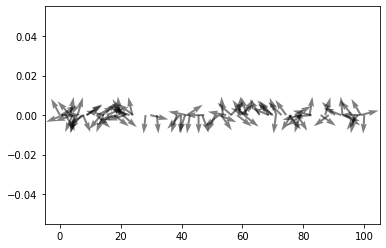

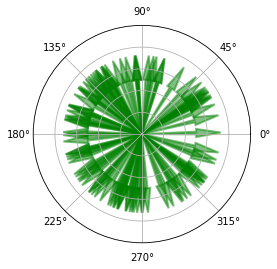

In [ ]:
def quivered(params,outData):
  g = 1/(params['tau']*(params['noise']/params['dt'])**2)
  x=np.reshape(outData['x'],(-1,params['N']))
  t=np.reshape(outData['t'],(-1,1))
  phis=np.reshape(outData['phi'],(-1,params['N']))
  posx = x[-1]
  posy = np.zeros(shape=sim.params['N'])
  velx = np.cos(phis[-1])
  vely = np.sin(phis[-1])
  plt.quiver(posx,posy,velx,vely,alpha=0.5)
  plt.show()
  fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
  r = np.ones(params['N'])
  for theta in phis[-1]:
    ax.arrow(theta,0,0,0.5,width=0.05,lw=2,color='g',alpha=0.5)
  ax.set_yticklabels([])
  plt.show()
quivered(sim.params,sim.out)

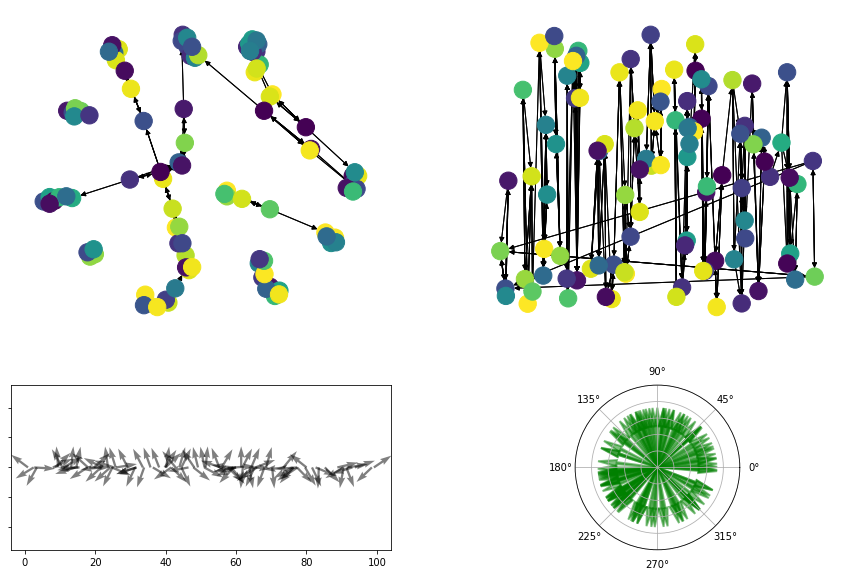

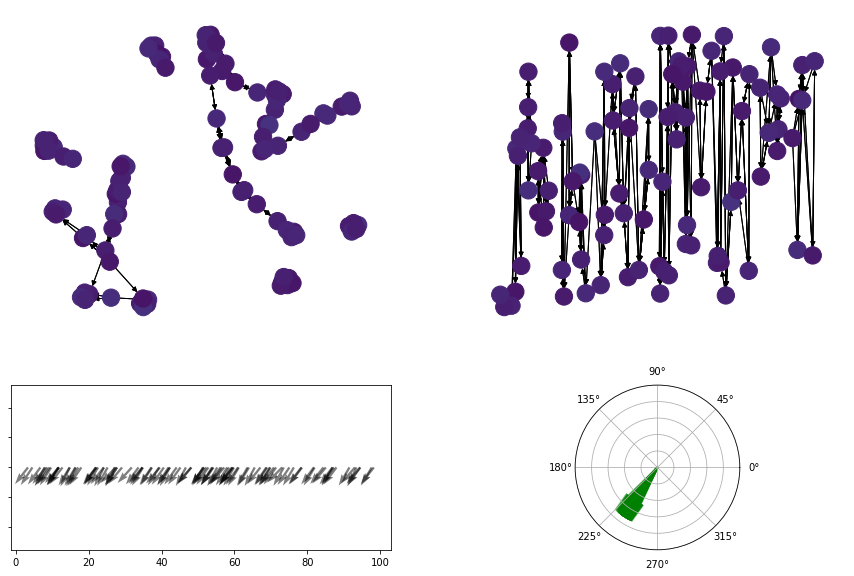

In [ ]:
#make a control panel with 4 subplots. make it an animation.
from matplotlib import gridspec

def everything(params,outData):

  # rendering
  fig = plt.figure(figsize=(15,10))
  gs  = gridspec.GridSpec(2, 2, height_ratios=[1,0.5])
  ax1 = plt.subplot(gs[0])
  ax2 = plt.subplot(gs[1])
  ax3 = plt.subplot(gs[2])
  ax4 = plt.subplot(gs[3],polar=True)

  #preprocessing
  g = 1/(params['tau']*(params['noise']/params['dt'])**2)
  x=np.reshape(outData['x'],(-1,params['N']))
  t=np.reshape(outData['t'],(-1,1))
  phis=np.reshape(outData['phi'],(-1,params['N']))
  
  #graph
  net = {'source':[],'dest':[],'data':[]}
  lastx = x[-1]
  for agent in range(params['N']):
    #boundary periodic
    bydist = []
    for nb in range(params['N']):
      dist = np.abs(lastx[nb] - lastx[agent])
      if dist > params['size']/2:
        dist = params['size'] - dist
      bydist.append(dist)
    nb = np.argsort(bydist)[1:params['k']+1]
    forces = []
    for n in nb:
      net['source'].append(agent)
      net['dest'].append(n)
      net['data'].append(np.abs(lastx[nb] - lastx[agent]))

  #ax1 = fig.add_subplot(221)
  graph = nx.DiGraph()
  graph.add_nodes_from([i for i in range(params['N'])])
  for i in graph.nodes():
    graph.nodes[i]['theta'] = phis[-1][i]
  for u,v,d in zip(net['source'], net['dest'],net['data']): 
    graph.add_edge(u, v,length=d)
  pos=nx.spring_layout(graph)
  vmin = -1
  vmax = 1
  sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
  sm.set_array([])
  #cbar = plt.colorbar(sm)
  colors = [np.sin(graph.nodes[i]['theta']) for i in graph.nodes()]
  nx.draw(graph,
          node_color=colors,
          pos=pos,cmap='viridis',vmin=vmin,vmax=vmax,ax=ax1)
  nx.draw_networkx_edges(
    graph, pos,  
    width=1, 
    label="S",
    arrowstyle='-|>',ax=ax1)

  #spatial network
  #ax2 = fig.add_subplot(222)
  graph = nx.DiGraph()
  graph.add_nodes_from([i for i in range(params['N'])])
  for i in graph.nodes():
    graph.nodes[i]['theta'] = phis[-1][i]
  for u,v,d in zip(net['source'], net['dest'],net['data']): 
    graph.add_edge(u, v)
  for i in graph.nodes():
    graph.nodes[i]['pos'] = [x[-1,i],np.random.uniform()] #jittered
  pos=nx.get_node_attributes(graph,'pos')
  vmin = -1
  vmax = 1
  sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
  sm.set_array([])
  #cbar = plt.colorbar(sm)
  colors = [np.sin(graph.nodes[i]['theta']) for i in graph.nodes()]
  nx.draw(graph,
          node_color=colors,
          pos=pos,cmap='viridis',vmin=vmin,vmax=vmax,ax=ax2)
  nx.draw_networkx_edges(
    graph, pos,  
    width=1, 
    label="S",
    arrowstyle='-|>',ax=ax2)
  
  g = 1/(params['tau']*(params['noise']/params['dt'])**2)
  x=np.reshape(outData['x'],(-1,params['N']))
  t=np.reshape(outData['t'],(-1,1))
  phis=np.reshape(outData['phi'],(-1,params['N']))
  posx = x[-1]
  posy = np.zeros(shape=sim.params['N'])
  velx = np.cos(phis[-1])
  vely = np.sin(phis[-1])
  #ax3 = fig.add_subplot(223)
  ax3.quiver(posx,posy,velx,vely,alpha=0.5)
  ax3.set_yticklabels([])
  #ax4 = fig.add_subplot(224, polar=True)
  r = np.ones(params['N'])
  for theta in phis[-1]:
    ax4.arrow(theta,0,0,0.5,width=0.05,lw=2,color='g',alpha=0.5)
  ax4.set_yticklabels([])
  
  plt.show()

#sanity
steps = 100
sim = Simulation(N=100,k=3,size=100)
sim.init_data()
sim.document(0)
everything(sim.params,sim.out)
for step in range(steps):
  sim.update_interaction()
  sim.update_agents()
  sim.document(step)
everything(sim.params,sim.out)

# Sanity tests

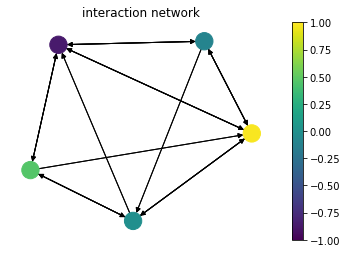

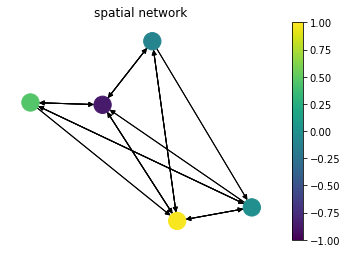

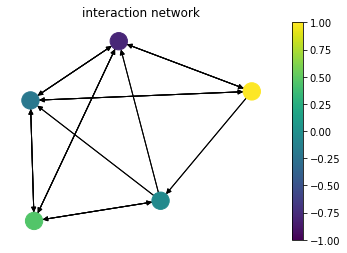

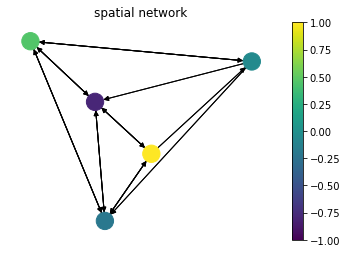

In [ ]:
#sanity
sim = Simulation(N=5,k=3,size=1)
sim.init_data()
#boundary: need nearest from other end for 0.9
sim.agentData['x']=[0.01,0.3,0.5,0.6,0.9]
sim.agentData['phi']=2*np.pi*np.random.random(size=sim.params['N'])
sim.agentData['force']=np.zeros(sim.params['N'])
sim.agentData['v']=sim.params['speed']*np.cos(sim.agentData['phi'])
sim.document(0)
graphit(sim.params,sim.out)
sim.update_interaction()
sim.update_agents()
sim.document(1)
graphit(sim.params,sim.out)

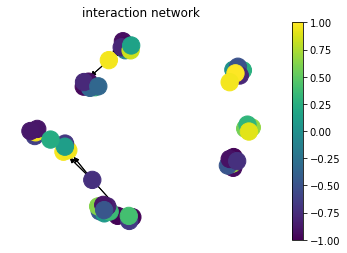

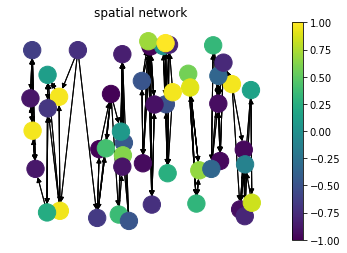

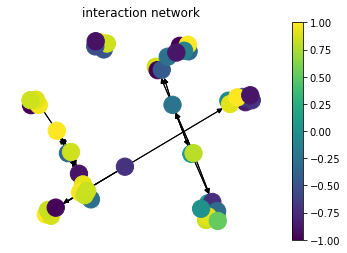

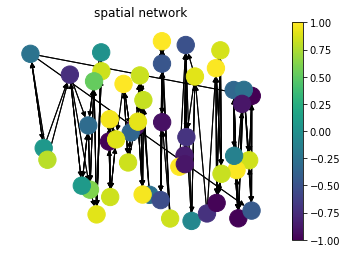

In [ ]:
#bad noise
steps = 300
sim = Simulation(N=50,k=3,size=100,noise=1.5)
sim.init_data()
sim.document(0)
graphit(sim.params,sim.out)
for step in range(steps):
  sim.update_interaction()
  sim.update_agents()
  sim.document(step)
graphit(sim.params,sim.out)

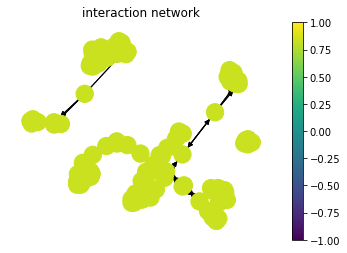

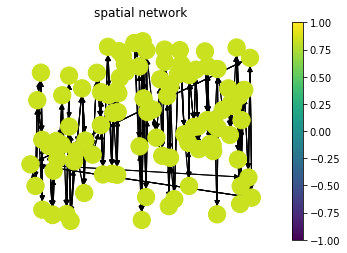

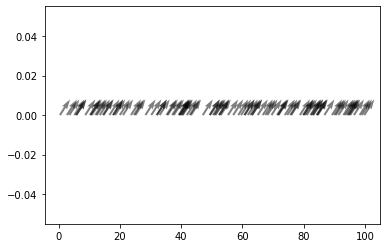

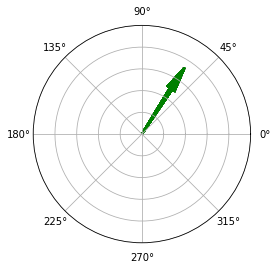

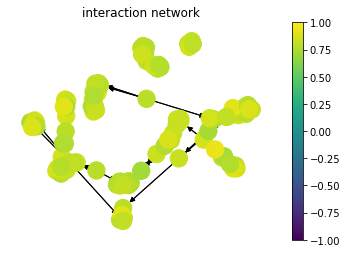

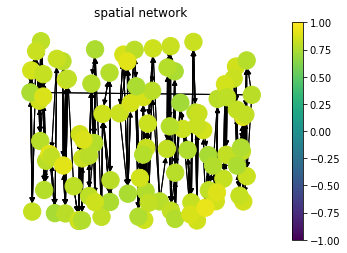

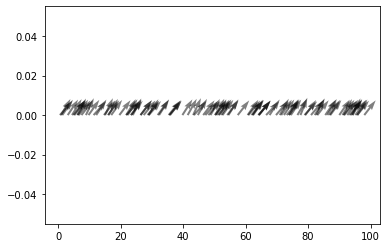

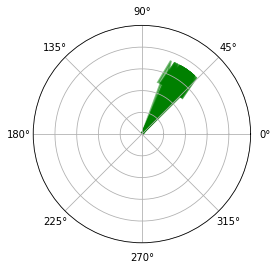

In [ ]:
#already ordered
#sanity
steps = 200
sim = Simulation(N=100,k=3,size=100)
sim.init_data()
sim.agentData['x']=sim.params['size']*np.random.uniform(size=sim.params['N'])
sim.agentData['phi']=np.ones(sim.params['N'])
sim.agentData['force']=np.zeros(sim.params['N'])
sim.agentData['v']=sim.params['speed']*np.cos(sim.agentData['phi'])
sim.document(0)
graphit(sim.params,sim.out)
quivered(sim.params,sim.out)

for step in range(steps):
  sim.update_interaction()
  sim.update_agents()
  sim.document(step)
graphit(sim.params,sim.out)
quivered(sim.params,sim.out)


# Uncertainty

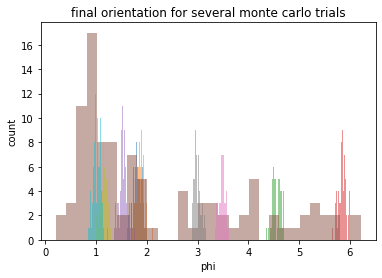

In [ ]:
#randomness
#same thing 10 trials -- different polarization

def get():
  sim = Simulation(tau=1,k=5,simtime=100)
  params,outData = sim.run()
  g = 1/(params['tau']*(params['noise']/params['dt'])**2)
  x=np.reshape(outData['x'],(-1,params['N']))
  ts=np.reshape(outData['t'],(-1,1))
  phis=np.reshape(outData['phi'],(-1,params['N']))
  plt.hist(phis[100],alpha=0.5,bins=30)

for i in range(10):
  get()
plt.xlabel("phi")
plt.ylabel("count")
plt.title("final orientation for several monte carlo trials")
plt.show()

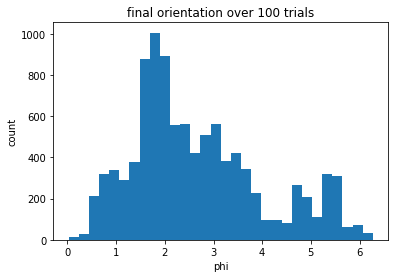

In [ ]:
#randomness
#same thing 10 trials -- different polarization

cumu = []
def get():
  sim = Simulation(tau=1,k=5,simtime=100)
  params,outData = sim.run()
  g = 1/(params['tau']*(params['noise']/params['dt'])**2)
  x=np.reshape(outData['x'],(-1,params['N']))
  ts=np.reshape(outData['t'],(-1,1))
  phis=np.reshape(outData['phi'],(-1,params['N']))
  for phi in phis[100]:
    cumu.append(phi)
for i in range(100):
  get()
plt.hist(cumu,bins=30)
plt.xlabel("phi")
plt.ylabel("count")
plt.title("final orientation over 100 trials")
plt.show()

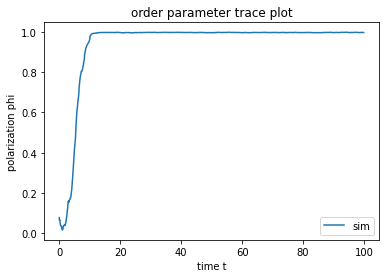

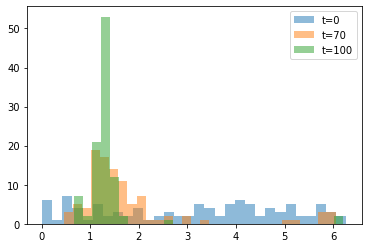

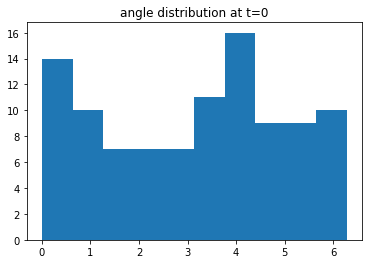

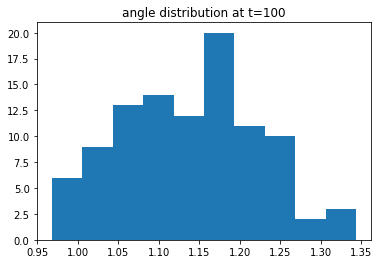

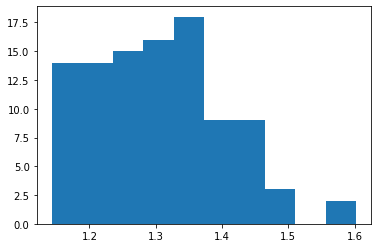

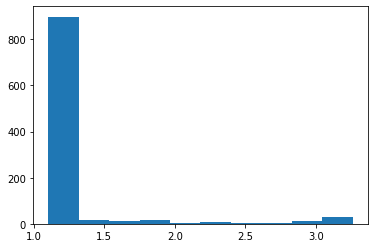

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


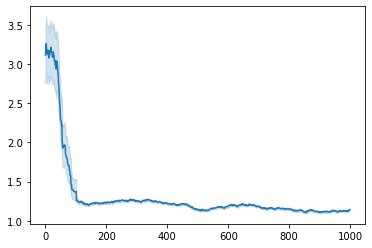

In [ ]:
#sanity check
#neighbors
sim = Simulation(tau=1,k=3,simtime=100)
params1,outData1 = sim.run()
sim = Simulation(tau=1,k=5,simtime=100)
params2,outData2 = sim.run()
sim = Simulation(tau=1,k=9,simtime=100)
params3,outData3 = sim.run()

#preprocessing
params = params1
outData = outData1
g = 1/(params['tau']*(params['noise']/params['dt'])**2)
x=np.reshape(outData['x'],(-1,params['N']))
ts=np.reshape(outData['t'],(-1,1))
phis=np.reshape(outData['phi'],(-1,params['N']))

#polarization
allu = []
allt = []
for i in range(len(ts)): #time
    coss = []
    sins = []
    for j in phis[i]: #agent
        coss.append(np.cos(j))
        sins.append(np.sin(j))
    polar = np.sqrt(np.average(coss)**2 + np.average(sins)**2)
    allt.append(ts[i])
    allu.append(polar)
plt.plot(allt,allu,label='sim')
plt.xlabel('time t')
plt.ylabel('polarization phi')
plt.title("order parameter trace plot")
plt.legend()
plt.show()



#distribution
plt.hist(phis[0],alpha=0.5,bins=30,label="t=0")
plt.hist(phis[70],alpha=0.5,bins=30,label="t=70")
plt.hist(phis[100],alpha=0.5,bins=30,label="t=100")
plt.legend()
plt.show()
plt.hist(phis[0])
plt.title("angle distribution at t=0")
plt.show() #last angle
plt.hist(phis[-1])
plt.title("angle distribution at t=100")
plt.show() #last angle
plt.hist([np.average(phis[:,i]) for i in range(params['N'])])
plt.show() #each agent's over time average
plt.hist([np.average(phis[i,:]) for i in range(params['steps'])])
plt.show() #each time step's average

slice = []
tt = []
for t in range(params['steps']):
    for j in range(params['N']):
        slice.append(phis[t,j])
        tt.append(t)
sns.lineplot(tt,slice)
plt.show() #each time step's average


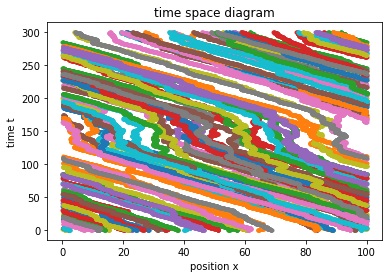

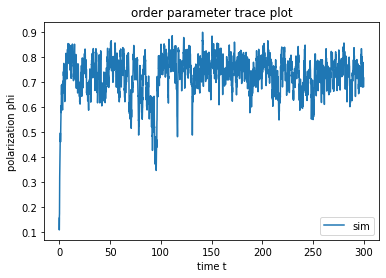

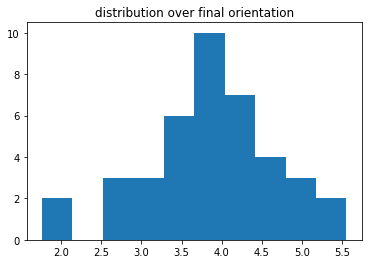

In [ ]:
sim = Simulation(N=40,tau=1,k=3,simtime=300,noise=1)
params,outData = sim.run()

#preprocessing
#g = 1/(params['tau']*(params['noise']/params['dt'])**2)
x=np.reshape(outData['x'],(-1,params['N']))
t=np.reshape(outData['t'],(-1,1))
phis=np.reshape(outData['phi'],(-1,params['N']))

#timespace
for i in range(params['N']):
  plt.plot(x[:,i],t,'.') # agent 0
plt.xlabel('position x')
plt.ylabel('time t')
plt.title("time space diagram")
plt.show()

#polarization
allu = []
allt = []
for i in range(len(t)): #time
    coss = []
    sins = []
    for j in phis[i]: #agent
        coss.append(np.cos(j))
        sins.append(np.sin(j))
    polar = np.sqrt(np.average(coss)**2 + np.average(sins)**2)
    allt.append(t[i])
    allu.append(polar)
plt.plot(allt,allu,label='sim')
plt.xlabel('time t')
plt.ylabel('polarization phi')
plt.title("order parameter trace plot")
plt.legend()
plt.show()

#final angle distribution
plt.hist(phis[-1])
plt.title("distribution over final orientation")
plt.show()

# Parameter analysis

In [ ]:
def statpol(params,outData):
  g = 1/(params['tau']*(params['noise']/params['dt'])**2)
  x=np.reshape(outData['x'],(-1,params['N']))
  ts=np.reshape(outData['t'],(-1,1))
  phis=np.reshape(outData['phi'],(-1,params['N']))

  allu = []
  allt = []
  for i in range(-30,-1): #stationary phase
      coss = []
      sins = []
      for j in phis[i]: #agent
          coss.append(np.cos(j))
          sins.append(np.sin(j))
      polar = np.sqrt(np.average(coss)**2 + np.average(sins)**2)
      allt.append(ts[i])
      allu.append(polar)
  pol = np.average(allu)
  return pol

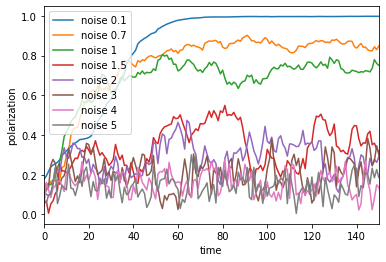

In [ ]:
ns = [0.1,0.7,1,1.5,2,3,4,5] #noise
xs = [] #melted
ys = [] #pol

for n in ns:
  
  sim = Simulation(noise=n,tau=1,N=100,size=100,k=3,simtime=100)
  params,outData= sim.run()

  x=np.reshape(outData['x'],(-1,params['N']))
  t=np.reshape(outData['t'],(-1,1))
  phis=np.reshape(outData['phi'],(-1,params['N']))
  t=np.reshape(outData['t'],(-1,1))

  allu = []
  allt = []
  for i in range(len(t)): #2nd half
      coss = []
      sins = []
      for j in phis[i]: #agent
          coss.append(np.cos(j))
          sins.append(np.sin(j))
      polar = np.sqrt(np.average(coss)**2 + np.average(sins)**2)
      allt.append(i)
      allu.append(polar)
  plt.plot(allt,allu,label=f"noise {n}")
plt.xlim(0,150)
plt.xlabel("time")
plt.ylabel("polarization")
plt.legend()
plt.show()

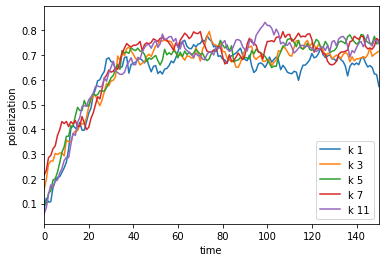

In [ ]:
ks = [1,3,5,7,11] #nbs
xs = [] #melted
ys = [] #pol
for k in ks:
  sim = Simulation(noise=1,tau=1,N=100,size=100,k=k,simtime=100)
  params,outData= sim.run()

  x=np.reshape(outData['x'],(-1,params['N']))
  t=np.reshape(outData['t'],(-1,1))
  phis=np.reshape(outData['phi'],(-1,params['N']))
  t=np.reshape(outData['t'],(-1,1))

  allu = []
  allt = []
  for i in range(len(t)): #2nd half
      coss = []
      sins = []
      for j in phis[i]: #agent
          coss.append(np.cos(j))
          sins.append(np.sin(j))
      polar = np.sqrt(np.average(coss)**2 + np.average(sins)**2)
      allt.append(i)
      allu.append(polar)
  plt.plot(allt,allu,label=f"k {k}")
plt.xlim(0,150)
plt.xlabel("time")
plt.ylabel("polarization")
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


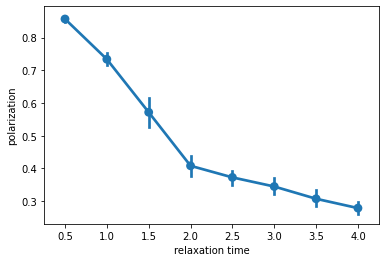

In [ ]:
ts = [0.5,1,1.5,2,2.5,3,3.5,4] #relax
xs = [] #melted
ys = [] #pol
trials = 10
for tau in ts:
  for trial in range(trials):
    sim = Simulation(N=100,tau=tau,k=3, noise=1,simtime=60)
    params,outData = sim.run()
    xs.append(tau)
    ys.append(statpol(params,outData))
sns.pointplot(xs,ys)
plt.xlabel("relaxation time")
plt.ylabel("polarization")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


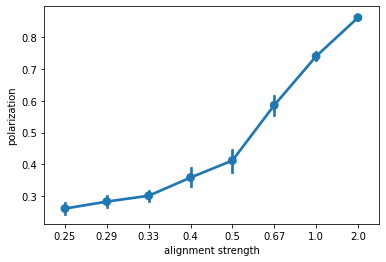

In [ ]:
ts = [0.5,1,1.5,2,2.5,3,3.5,4] #relax
xs = [] #melted
ys = [] #pol
trials = 10
for tau in ts:
  for trial in range(trials):
    sim = Simulation(N=100,tau=tau,k=3, noise=1,simtime=60)
    params,outData = sim.run()
    xs.append(np.round(1/tau,2))
    ys.append(statpol(params,outData))
sns.pointplot(xs,ys)
plt.xlabel("alignment strength")
plt.ylabel("polarization")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


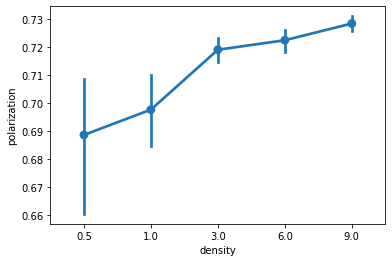

In [ ]:
rs = [0.5,1,3,6,9] #density
xs = [] #melted
ys = [] #pol
trials = 30
for x in rs:
  for trial in range(trials):
    sim = Simulation(N=int(x*100),tau=1,k=2,simtime=100,noise=1)
    params,outData = sim.run()
    xs.append(x)
    ys.append(statpol(params,outData))
sns.pointplot(xs,ys)
plt.xlabel("density")
plt.ylabel("polarization")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


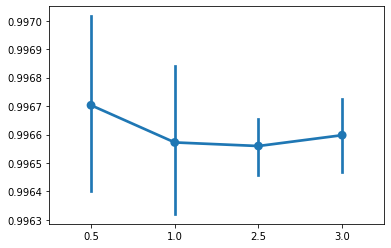

In [ ]:
rs = [0.5,1,2.5,3] #density
xs = [] #melted
ys = [] #pol
trials = 10
for x in rs:
  for trial in range(trials):
    sim = Simulation(N=int(x*100),tau=1,k=2,simtime=60)
    params,outData = sim.run()
    xs.append(x)
    ys.append(statpol(params,outData))
sns.pointplot(xs,ys)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


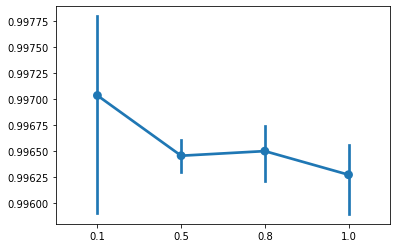

In [ ]:
rs = [0.1,0.5,0.8,1] #density
xs = [] #melted
ys = [] #pol
trials = 10
for x in rs:
  for trial in range(trials):
    sim = Simulation(N=int(x*100),tau=1,k=2,simtime=100,noise=.1)
    params,outData = sim.run()
    xs.append(x)
    ys.append(statpol(params,outData))
sns.pointplot(xs,ys)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


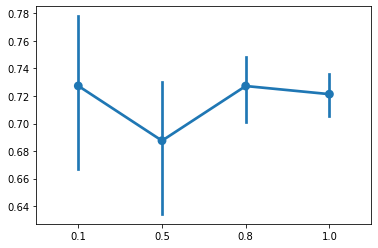

In [ ]:
rs = [0.1,0.5,0.8,1] #density
xs = [] #melted
ys = [] #pol
trials = 10
for x in rs:
  for trial in range(trials):
    sim = Simulation(N=int(x*100),tau=1,k=2,simtime=100,noise=1)
    params,outData = sim.run()
    xs.append(x)
    ys.append(statpol(params,outData))
sns.pointplot(xs,ys)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


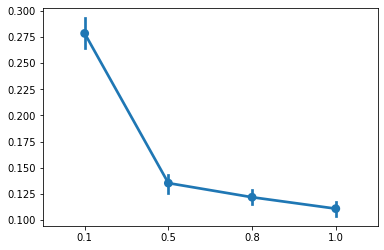

In [ ]:
rs = [0.1,0.5,0.8,1] #density
xs = [] #melted
ys = [] #pol
trials = 10
for x in rs:
  for trial in range(trials):
    sim = Simulation(N=int(x*100),tau=1,k=2,simtime=100,noise=10)
    params,outData = sim.run()
    xs.append(x)
    ys.append(statpol(params,outData))
sns.pointplot(xs,ys)
plt.show()

In [ ]:
#confint
import scipy
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

ns = [1]
trials = 30
for n in ns:
  ys = [] #pol
  for trial in range(trials):
    sim = Simulation(N=100,tau=1,k=2,simtime=100,noise=n)
    params,outData = sim.run()
    xs.append(n)
    ys.append(statpol(params,outData))
  print(mean_confidence_interval(ys))
  print(ys)

(0.7018949802821766, 0.6862291369267395, 0.7175608236376136)
[0.69028530905402, 0.6840703353817352, 0.6747769985709248, 0.7003636179384571, 0.7445545824201573, 0.7218527272243633, 0.6798797624296128, 0.7091418743437868, 0.7666803255722988, 0.6731713704037052, 0.7363299563944673, 0.7237571396548647, 0.6474039065053458, 0.6953385304365851, 0.7105657537798242, 0.6075529975305906, 0.6644835813308817, 0.7085553983540245, 0.5883786623240342, 0.720930549272648, 0.7556479191487258, 0.7341067622990785, 0.7197603789060608, 0.7284093987722524, 0.6328496326708452, 0.747682437598602, 0.712311003775293, 0.7196382724525433, 0.7273955822817892, 0.7309746416377796]


(0.7018949802821766, 0.6862291369267395, 0.7175608236376136)
(0.39073110663526617, 0.3695643588095144, 0.41189785446101795)


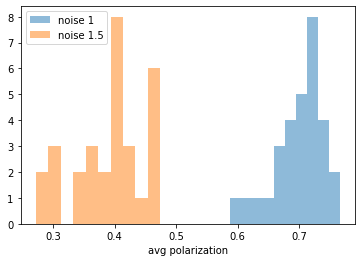

In [ ]:
n1 = [0.69028530905402, 0.6840703353817352, 0.6747769985709248, 0.7003636179384571, 0.7445545824201573, 0.7218527272243633, 0.6798797624296128, 0.7091418743437868, 0.7666803255722988, 0.6731713704037052, 0.7363299563944673, 0.7237571396548647, 0.6474039065053458, 0.6953385304365851, 0.7105657537798242, 0.6075529975305906, 0.6644835813308817, 0.7085553983540245, 0.5883786623240342, 0.720930549272648, 0.7556479191487258, 0.7341067622990785, 0.7197603789060608, 0.7284093987722524, 0.6328496326708452, 0.747682437598602, 0.712311003775293, 0.7196382724525433, 0.7273955822817892, 0.7309746416377796]
n2 = [0.41681876815720337, 0.40170373901736156, 0.4061335621430315, 0.40314411457317934, 0.46355085332552204, 0.4491119955815263, 0.3348747838289543, 0.2948216391916649, 0.3554868344287865, 0.4649958521583487, 0.29142769732504814, 0.4562407179188266, 0.3609013367856281, 0.3951220441857933, 0.27191608327834343, 0.4546858107837561, 0.38911041237265737, 0.41181520418150747, 0.419642037743648, 0.4031058116828049, 0.3740121515283119, 0.46387943807029336, 0.37005268455763657, 0.31153280774997244, 0.3986613830366764, 0.30456823773652286, 0.3520070191339625, 0.4071193714223262, 0.4743304032290099, 0.4211604039296819]
print(mean_confidence_interval(n1))
print(mean_confidence_interval(n2))

plt.hist(n1,label="noise 1",alpha=0.5)
plt.hist(n2,label="noise 1.5",alpha=0.5)
plt.xlabel("avg polarization")
plt.legend()
plt.show()

In [ ]:
scipy.stats.ttest_ind(n1,n2)

Ttest_indResult(statistic=24.1670541345018, pvalue=5.730354075463211e-32)

In [ ]:
print(ys)

[0.41681876815720337, 0.40170373901736156, 0.4061335621430315, 0.40314411457317934, 0.46355085332552204, 0.4491119955815263, 0.3348747838289543, 0.2948216391916649, 0.3554868344287865, 0.4649958521583487, 0.29142769732504814, 0.4562407179188266, 0.3609013367856281, 0.3951220441857933, 0.27191608327834343, 0.4546858107837561, 0.38911041237265737, 0.41181520418150747, 0.419642037743648, 0.4031058116828049, 0.3740121515283119, 0.46387943807029336, 0.37005268455763657, 0.31153280774997244, 0.3986613830366764, 0.30456823773652286, 0.3520070191339625, 0.4071193714223262, 0.4743304032290099, 0.4211604039296819]


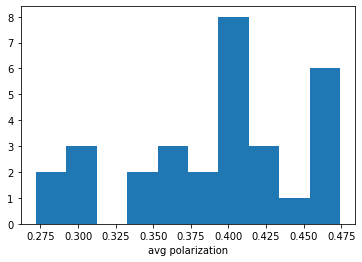

In [ ]:
plt.hist(ys)
plt.xlabel("avg polarization")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


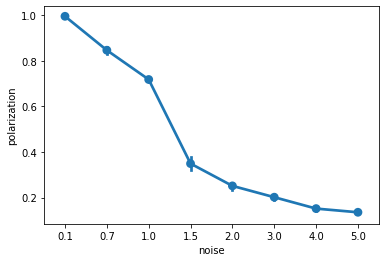

In [ ]:
ns = [0.1,0.7,1,1.5,2,3,4,5] #noise
xs = [] #melted
ys = [] #pol
trials = 10
for n in ns:
  for trial in range(trials):
    sim = Simulation(N=100,tau=1,k=2,simtime=100,noise=n)
    params,outData = sim.run()
    xs.append(n)
    ys.append(statpol(params,outData))
sns.pointplot(xs,ys)
plt.xlabel("noise")
plt.ylabel("polarization")
plt.show()

In [ ]:
from networkx.algorithms.hybrid import kl_connected_subgraph
#confint
import scipy
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

ks = [2,8]
trials = 30
for k in ks:
  ys = [] #pol
  for trial in range(trials):
    sim = Simulation(N=100,tau=1,k=k,simtime=150,noise=1)
    params,outData = sim.run()
    ys.append(statpol(params,outData))
  print(mean_confidence_interval(ys))
  print(ys)

(0.6949144229612446, 0.6743306058400608, 0.7154982400824285)
[0.68753850343692, 0.7204410933892068, 0.6802207801777989, 0.7602771185891058, 0.733938495400807, 0.7243903126771335, 0.6720701411316802, 0.7416396653925763, 0.704008724851485, 0.5940297222473113, 0.7087098353062293, 0.7318099897447939, 0.6776933284959222, 0.6959350038418977, 0.7303195869812928, 0.7264308926416413, 0.6594146833251077, 0.7338832234810874, 0.6950636204557763, 0.701888479348542, 0.6733790425576655, 0.7141309189068414, 0.7265700597176469, 0.7227195954735042, 0.6848290126332262, 0.6893491658317215, 0.7230872944320464, 0.6679237264314345, 0.7079237207669309, 0.45781695116999915]
(0.7497028096308814, 0.742247960868661, 0.7571576583931019)
[0.773780105291459, 0.7711677179472364, 0.7727760301631519, 0.7703890746305223, 0.7539485924177538, 0.7309937539091784, 0.7588139493862324, 0.7323171821921628, 0.7510637814755203, 0.7884183483105517, 0.7246292787369699, 0.7313919895235452, 0.747173547892262, 0.7630689788453309, 0.7

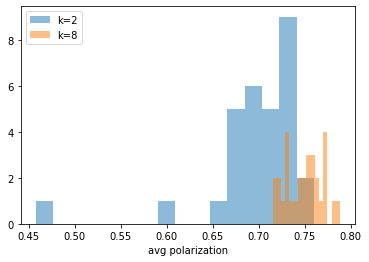

In [ ]:
k1= [0.68753850343692, 0.7204410933892068, 0.6802207801777989, 0.7602771185891058, 0.733938495400807, 0.7243903126771335, 0.6720701411316802, 0.7416396653925763, 0.704008724851485, 0.5940297222473113, 0.7087098353062293, 0.7318099897447939, 0.6776933284959222, 0.6959350038418977, 0.7303195869812928, 0.7264308926416413, 0.6594146833251077, 0.7338832234810874, 0.6950636204557763, 0.701888479348542, 0.6733790425576655, 0.7141309189068414, 0.7265700597176469, 0.7227195954735042, 0.6848290126332262, 0.6893491658317215, 0.7230872944320464, 0.6679237264314345, 0.7079237207669309, 0.45781695116999915]

k2 = [0.773780105291459, 0.7711677179472364, 0.7727760301631519, 0.7703890746305223, 0.7539485924177538, 0.7309937539091784, 0.7588139493862324, 0.7323171821921628, 0.7510637814755203, 0.7884183483105517, 0.7246292787369699, 0.7313919895235452, 0.747173547892262, 0.7630689788453309, 0.7237752061872168, 0.7357387655901599, 0.7173147932211423, 0.7401591975003595, 0.766379833143223, 0.7607750791819289, 0.7638730446309836, 0.752416360562026, 0.7834855057783808, 0.7321563000753858, 0.7555722791046641, 0.7149468463751831, 0.7462814380017166, 0.746654476310313, 0.7590882763642285, 0.7225345561776555]

plt.hist(k1,label="k=2",alpha=0.5,bins=16)
plt.hist(k2,label="k=8",alpha=0.5,bins=16)
plt.xlabel("avg polarization")
plt.legend()
plt.show()

In [ ]:
scipy.stats.ttest_ind(k1,k2)

Ttest_indResult(statistic=-5.118482696945561, pvalue=3.652560774864272e-06)

In [ ]:
from networkx.algorithms.hybrid import kl_connected_subgraph
#confint
import scipy
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

ds = [0.3,1.5]
trials = 30
for d in ds:
  ys = [] #pol
  for trial in range(trials):
    sim = Simulation(N=int(d*100),tau=1,k=3,simtime=150,noise=1)
    params,outData = sim.run()
    xs.append(k)
    ys.append(statpol(params,outData))
  print(mean_confidence_interval(ys))
  print(ys)

(0.30834891165619566, 0.289123861593226, 0.3275739617191653)
[0.33613817730681333, 0.3079511330716561, 0.3273014406490499, 0.1611178351083591, 0.3467467463288785, 0.36491628859052067, 0.2951334194894502, 0.19787660722265069, 0.2804180548130258, 0.37661945875520797, 0.30323222941999023, 0.30741146822449184, 0.30028933061512025, 0.2502503023370634, 0.3630216285558075, 0.37723905676494945, 0.28684231986516645, 0.2993925619019922, 0.34968801727411486, 0.2668568609570807, 0.3309742330820295, 0.32719585445678406, 0.31178236730148257, 0.22393316937979102, 0.34776436124905424, 0.29142214355291196, 0.36678945847385763, 0.28305441316518015, 0.35822338958561756, 0.31088502218777314]
(0.2639637172448825, 0.25131972282658904, 0.27660771166317594)
[0.3167182575925118, 0.23007066849226562, 0.22980765650161047, 0.2849916766990277, 0.25204296202345594, 0.2814624404322748, 0.2753814639518327, 0.30218649438963646, 0.2986879794145414, 0.30933312757001946, 0.29189482107976694, 0.2660514809122246, 0.2764283

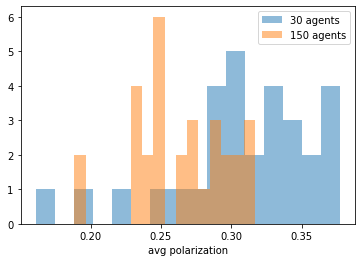

Ttest_indResult(statistic=3.9451019997778514, pvalue=0.00021776640509885842)


In [ ]:
r1 = [0.33613817730681333, 0.3079511330716561, 0.3273014406490499, 0.1611178351083591, 0.3467467463288785, 0.36491628859052067, 0.2951334194894502, 0.19787660722265069, 0.2804180548130258, 0.37661945875520797, 0.30323222941999023, 0.30741146822449184, 0.30028933061512025, 0.2502503023370634, 0.3630216285558075, 0.37723905676494945, 0.28684231986516645, 0.2993925619019922, 0.34968801727411486, 0.2668568609570807, 0.3309742330820295, 0.32719585445678406, 0.31178236730148257, 0.22393316937979102, 0.34776436124905424, 0.29142214355291196, 0.36678945847385763, 0.28305441316518015, 0.35822338958561756, 0.31088502218777314]
r2 = [0.3167182575925118, 0.23007066849226562, 0.22980765650161047, 0.2849916766990277, 0.25204296202345594, 0.2814624404322748, 0.2753814639518327, 0.30218649438963646, 0.2986879794145414, 0.30933312757001946, 0.29189482107976694, 0.2660514809122246, 0.2764283367841498, 0.27487716774878734, 0.1928484356202897, 0.24473741235154436, 0.24755567861983252, 0.2923213049777212, 0.3069624954425257, 0.18846658553417048, 0.2320097540690023, 0.24016258156586523, 0.2981569549391544, 0.26125987527776096, 0.31080444078079517, 0.234624618179117, 0.24564619761661277, 0.24276114257400658, 0.24524436368348385, 0.24541514252248772]

plt.hist(r1,label="30 agents",alpha=0.5,bins=16)
plt.hist(r2,label="150 agents",alpha=0.5,bins=16)
plt.xlabel("avg polarization")
plt.legend()
plt.show()
print(scipy.stats.ttest_ind(r1,r2))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


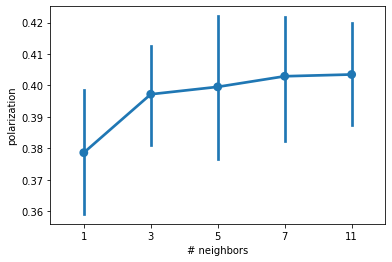

In [ ]:
ks = [1,3,5,7,11] #nbs
xs = [] #melted
ys = [] #pol
trials = 30
for k in ks:
  for trial in range(trials):
    sim = Simulation(N=100,tau=1,k=k,simtime=100,noise=1.5)
    params,outData = sim.run()
    xs.append(k)
    ys.append(statpol(params,outData))
sns.pointplot(xs,ys)
plt.xlabel("# neighbors")
plt.ylabel("polarization")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


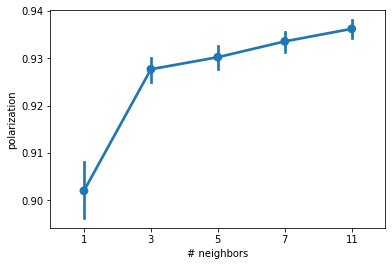

In [ ]:
ks = [1,3,5,7,11] #nbs
xs = [] #melted
ys = [] #pol
trials = 30
for k in ks:
  for trial in range(trials):
    sim = Simulation(N=100,tau=1,k=k,simtime=100,noise=0.5)
    params,outData = sim.run()
    xs.append(k)
    ys.append(statpol(params,outData))
sns.pointplot(xs,ys)
plt.xlabel("# neighbors")
plt.ylabel("polarization")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


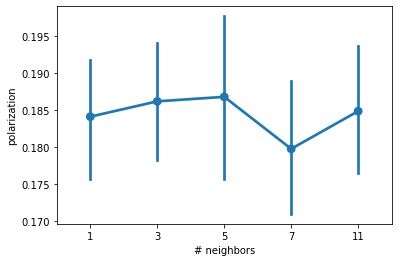

In [ ]:
ks = [1,3,5,7,11] #nbs
xs = [] #melted
ys = [] #pol
trials = 30
for k in ks:
  for trial in range(trials):
    sim = Simulation(N=100,tau=1,k=k,simtime=100,noise=3)
    params,outData = sim.run()
    xs.append(k)
    ys.append(statpol(params,outData))
sns.pointplot(xs,ys)
plt.xlabel("# neighbors")
plt.ylabel("polarization")
plt.show()

# Trace

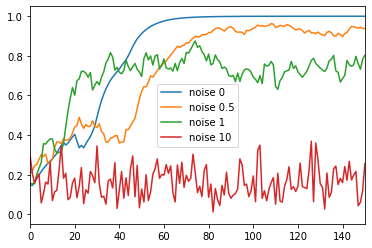

In [ ]:
noises = [0,0.5,1,10]
for n in noises:
  
  sim = Simulation(noise=n,tau=1,N=40,size=100,k=3,simtime=100)
  params,outData= sim.run()

  x=np.reshape(outData['x'],(-1,params['N']))
  t=np.reshape(outData['t'],(-1,1))
  phis=np.reshape(outData['phi'],(-1,params['N']))
  t=np.reshape(outData['t'],(-1,1))

  allu = []
  allt = []
  for i in range(len(t)): #2nd half
      coss = []
      sins = []
      for j in phis[i]: #agent
          coss.append(np.cos(j))
          sins.append(np.sin(j))
      polar = np.sqrt(np.average(coss)**2 + np.average(sins)**2)
      allt.append(i)
      allu.append(polar)
  plt.plot(allt,allu,label=f"noise {n}")
plt.xlim(0,150)
plt.legend()
plt.show()

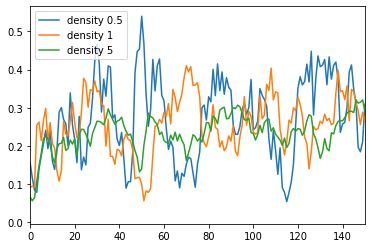

In [ ]:
densities = [0.5,1,5]
for d in densities:
  
  sim = Simulation(noise=2,tau=1,N=int(d*100),size=100,k=3,simtime=100)
  params,outData= sim.run()

  x=np.reshape(outData['x'],(-1,params['N']))
  t=np.reshape(outData['t'],(-1,1))
  phis=np.reshape(outData['phi'],(-1,params['N']))
  t=np.reshape(outData['t'],(-1,1))

  allu = []
  allt = []
  for i in range(len(t)): #2nd half
      coss = []
      sins = []
      for j in phis[i]: #agent
          coss.append(np.cos(j))
          sins.append(np.sin(j))
      polar = np.sqrt(np.average(coss)**2 + np.average(sins)**2)
      allt.append(i)
      allu.append(polar)
  plt.plot(allt,allu,label=f"density {d}")
plt.xlim(0,150)
plt.legend()
plt.show()

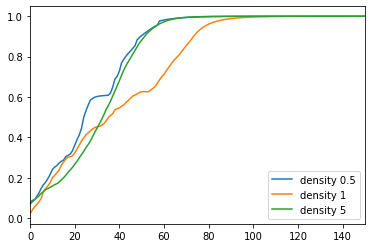

In [ ]:
densities = [0.5,1,5]
for d in densities:
  
  sim = Simulation(noise=0,tau=1,N=int(d*100),size=100,k=3,simtime=100)
  params,outData= sim.run()

  x=np.reshape(outData['x'],(-1,params['N']))
  t=np.reshape(outData['t'],(-1,1))
  phis=np.reshape(outData['phi'],(-1,params['N']))
  t=np.reshape(outData['t'],(-1,1))

  allu = []
  allt = []
  for i in range(len(t)): #2nd half
      coss = []
      sins = []
      for j in phis[i]: #agent
          coss.append(np.cos(j))
          sins.append(np.sin(j))
      polar = np.sqrt(np.average(coss)**2 + np.average(sins)**2)
      allt.append(i)
      allu.append(polar)
  plt.plot(allt,allu,label=f"density {d}")
plt.xlim(0,150)
plt.legend()
plt.show()

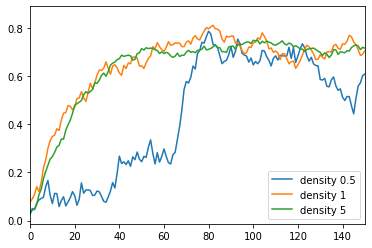

In [ ]:
densities = [0.5,1,5]
for d in densities:
  
  sim = Simulation(noise=1,tau=1,N=int(d*100),size=100,k=3,simtime=100)
  params,outData= sim.run()

  x=np.reshape(outData['x'],(-1,params['N']))
  t=np.reshape(outData['t'],(-1,1))
  phis=np.reshape(outData['phi'],(-1,params['N']))
  t=np.reshape(outData['t'],(-1,1))

  allu = []
  allt = []
  for i in range(len(t)): #2nd half
      coss = []
      sins = []
      for j in phis[i]: #agent
          coss.append(np.cos(j))
          sins.append(np.sin(j))
      polar = np.sqrt(np.average(coss)**2 + np.average(sins)**2)
      allt.append(i)
      allu.append(polar)
  plt.plot(allt,allu,label=f"density {d}")
plt.xlim(0,150)
plt.legend()
plt.show()

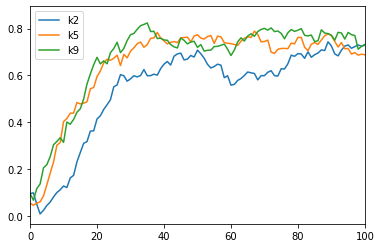

In [ ]:
ks = [2,5,9]
for k in ks:
  
  sim = Simulation(noise=1,tau=1,N=100,size=100,k=k,simtime=100)
  params,outData= sim.run()

  x=np.reshape(outData['x'],(-1,params['N']))
  t=np.reshape(outData['t'],(-1,1))
  phis=np.reshape(outData['phi'],(-1,params['N']))
  t=np.reshape(outData['t'],(-1,1))

  allu = []
  allt = []
  for i in range(len(t)): #2nd half
      coss = []
      sins = []
      for j in phis[i]: #agent
          coss.append(np.cos(j))
          sins.append(np.sin(j))
      polar = np.sqrt(np.average(coss)**2 + np.average(sins)**2)
      allt.append(i)
      allu.append(polar)
  plt.plot(allt,allu,label=f"k{k}")
plt.xlim(0,100)
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.


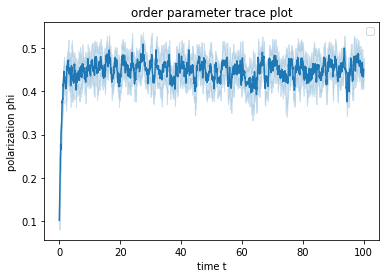

In [ ]:
trials = 10
allu = []
allt = []
for trial in range(trials):
  sim = Simulation(N=150,noise=2,tau=1,k=5,simtime=100)
  params1,outData1 = sim.run()

  #preprocessing
  params = params1
  outData = outData1
  g = 1/(params['tau']*(params['noise']/params['dt'])**2)
  x=np.reshape(outData['x'],(-1,params['N']))
  ts=np.reshape(outData['t'],(-1,1))
  phis=np.reshape(outData['phi'],(-1,params['N']))

  for i in range(len(ts)): #time
      coss = []
      sins = []
      for j in phis[i]: #agent
          coss.append(np.cos(j))
          sins.append(np.sin(j))
      polar = np.sqrt(np.average(coss)**2 + np.average(sins)**2)
      allt.append(ts[i][0])
      allu.append(float(polar))

sns.lineplot(allt,allu)
plt.xlabel('time t')
plt.ylabel('polarization phi')
plt.title("order parameter trace plot")
plt.legend()
plt.show()

# Correlation

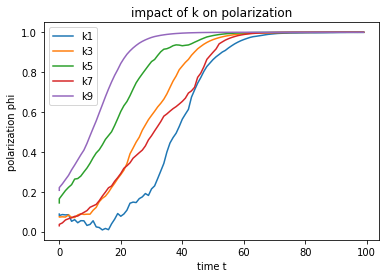

In [ ]:
ks = [1,3,5,7,9]
for k in ks:
  sim = Simulation(tau=10,k=k,simtime=100)
  params,outData = sim.run()

  #preprocessing
  g = 1/(params['tau']*(params['noise']/params['dt'])**2)
  x=np.reshape(outData['x'],(-1,params['N']))
  t=np.reshape(outData['t'],(-1,1))
  phis=np.reshape(outData['phi'],(-1,params['N']))
  
  allu = []
  allt = []
  for i in range(len(t)): #time
      coss = []
      sins = []
      for j in phis[i]: #agent
          coss.append(np.cos(j))
          sins.append(np.sin(j))
      polar = np.sqrt(np.average(coss)**2 + np.average(sins)**2)
      allt.append(t[i])
      allu.append(polar)
  plt.plot(allt,allu,label=f'k{k}')
plt.xlabel('time t')
plt.ylabel('polarization phi')
plt.title("impact of k on polarization")
plt.legend()
plt.show()

In [ ]:
ks = [1,3,5,7,9]
trials = 10
simtime = 300
allk = []
allu = []
allt = []
for k in ks:
  thist = []
  thisu = []
  for trial in range(trials):

    sim = Simulation(tau=1,k=k,simtime=simtime)
    params,outData = sim.run()

    #preprocessing
    g = 1/(params['tau']*(params['noise']/params['dt'])**2)
    x=np.reshape(outData['x'],(-1,params['N']))
    t=np.reshape(outData['t'],(-1,1))
    phis=np.reshape(outData['phi'],(-1,params['N']))

    #polarization
    for i in range(len(t)): #time
        coss = []
        sins = []
        for j in phis[i]: #agent
            coss.append(np.cos(j))
            sins.append(np.sin(j))
        polar = np.sqrt(np.average(coss)**2 + np.average(sins)**2)
        thist.append(t[i][0])
        thisu.append(polar)
        allk.append(k)
        allt.append(t[i][0])
        allu.append(polar)
  sns.lineplot(thist,thisu,label=f'tau={tau}')
plt.xlabel('time t')
plt.ylabel('polarization phi')
plt.title("order parameter trace plot")
plt.xlim(0,100)
plt.legend()
plt.show()

In [ ]:
taus = [0.01,100]
trials = 10
simtime = 300
alltau = []
allu = []
allt = []
for tau in taus:
  thist = []
  thisu = []
  for trial in range(trials):

    sim = Simulation(tau=tau,k=5,simtime=simtime)
    params,outData = sim.run()

    #preprocessing
    g = 1/(params['tau']*(params['noise']/params['dt'])**2)
    x=np.reshape(outData['x'],(-1,params['N']))
    t=np.reshape(outData['t'],(-1,1))
    phis=np.reshape(outData['phi'],(-1,params['N']))

    #polarization
    for i in range(len(t)): #time
        coss = []
        sins = []
        for j in phis[i]: #agent
            coss.append(np.cos(j))
            sins.append(np.sin(j))
        polar = np.sqrt(np.average(coss)**2 + np.average(sins)**2)
        thist.append(t[i][0])
        thisu.append(polar)
        alltau.append(tau)
        allt.append(t[i][0])
        allu.append(polar)
  sns.lineplot(thist,thisu,label=f'tau={tau}')
plt.xlabel('time t')
plt.ylabel('polarization phi')
plt.title("order parameter trace plot")
plt.xlim(0,100)
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 93.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 91.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


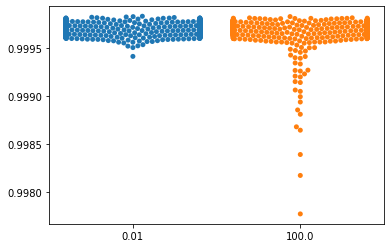

In [ ]:
import pandas as pd
data = [alltau,allt,allu]
data = np.array(data).transpose()
df = pd.DataFrame(data,columns=['tau','t','u'])
df.head()
cutoff = 80
stat = []
for tau in taus:
  this_series = df[df['tau']==tau]
  stationary = this_series[this_series['t']>cutoff]
  stat.append(np.array(stationary['u']))
x = []
y = []
for tau in range(len(stat)):
  for item in range(len(stat[tau])):
    x.append(taus[tau])
    y.append(stat[tau][item])
sns.swarmplot(x,y)
plt.show()

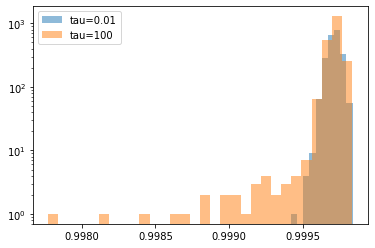

tau1 = 0.01, g1 = 999999.9999999999
tau2 = 100, g1 = 100.0


In [ ]:
plt.hist(stat[0],label=f"tau={taus[0]}",alpha=0.5,bins=10)
plt.hist(stat[1],label=f"tau={taus[1]}",alpha=0.5,bins=30)
plt.legend()
plt.yscale("log")
plt.show()
print(f"tau1 = {taus[0]}, g1 = {(1)/(taus[0]*(params['sigma_dt']*params['dt'])**2)}")
print(f"tau2 = {taus[1]}d, g1 = {(1)/(taus[1]*(params['sigma_dt']*params['dt'])**2)}")

In [ ]:
#alignment strength range
print(f"simtime={params['simtime']}")
tau1 = 100000 #ub
tau2 = 1000000 #lb
print(f"tau1 = {tau1}, g1 = {(1)/(tau1*(params['sigma_dt']*params['dt'])**2)}")
print(f"tau2 = {tau2}, g2 = {(1)/(tau2*(params['sigma_dt']*params['dt'])**2)}")
print(f"tau={params['tau']}, sigma_dt={params['sigma_dt']}, dt={params['dt']}")

#doesn't make sense! what is relaxation time? what is the normal range? why would varying it change anything?

simtime=10
tau1 = 100000, g1 = 1.0
tau2 = 1000000, g2 = 0.1
tau=1, sigma_dt=0.03162277660168379, dt=0.1


https://link.springer.com/content/pdf/10.1140/epjst/e2008-00634-x.pdf